## Analysis of flat10MIP output

In [2]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

In [3]:
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_grid, select_time_slice, weighted_temporal_mean 

### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [4]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']


In [5]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [6]:
# initialize a dictionary to hold all of the data
data_dict={}

### Define Functions

### Load grid info

In [7]:
data_dict = load_grid(data_dict,modellist)

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


### Load data

In [8]:
data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


loading model: ACCESS-ESM1-5
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_zec to dict
loading run: *cdr
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_cdr to dict
loading model: CESM2
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10_ze

In [9]:
modellist=modellist_orig
varlist=varlist_analyze

In [10]:
ds=data_dict[modellist[0] +'_' +runlist[0]]
ds


<xarray.Dataset>
Dimensions:    (time: 2400, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0300-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 0101-01-01 00:00:00 ... 0301-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.38 -89.38 ... 89.38 90.0
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 359.1
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cTot       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nep        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    gpp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    rh         (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    contact:                access_csiro@csiro.au
    ...                     ...
    variable_id:            cVeg
    variant_label:          r1i1p1f2
    version:                v20231220
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/bf249875-1619-427f-9b89-f01bdb599a9a

(0.0, 2.0)

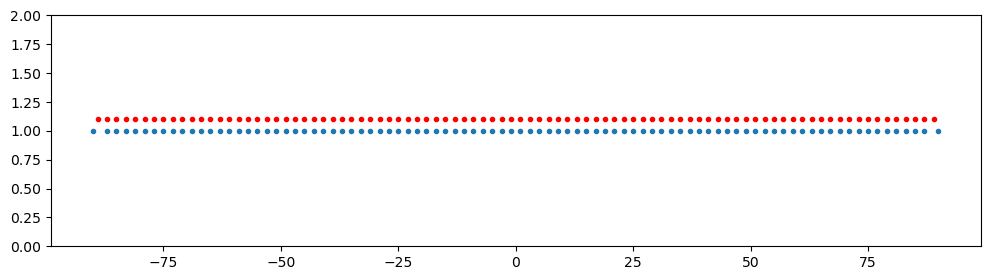

In [11]:
# grid for GISS has correct dimensions but different lat values at polar most gridcell
# the grid file came from PCMDI because GISS didn't supply a grid file
# not fixing this at the moment, but it could become a problem later

fig = plt.figure(figsize=(12,3))
ds= data_dict['GISS_E2.1_' +runlist[0]]
landfrac= data_dict['GISS_E2.1_' +'landfrac']

plt.plot(ds.lat,np.ones(len(ds.lat)),'.')
plt.plot(landfrac.lat,1.1*np.ones(len(landfrac.lat)),'.',color='red')
plt.ylim([0,2])


# Calculate Metrics

### zonal average land sink

Zonal average land sink is calculated from total carbon on land averaged into latitude bands

In [12]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('loading run: ' +run)


        ds=data_dict[modellist[m] +'_' +runlist[e]]
        ds_area = data_dict[modellist[m] +'_' +'areacella']
        ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
        #area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
        #landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)
        
        
        if model=='CESM2':
            area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
        else:
            area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
            landfrac=landfrac/100
            
        landarea=area*landfrac
        
        troplat=30
        highlat=60
        


        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            #print('loading variable: ' +var)

            data_var= weighted_temporal_mean(ds, var)

            # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
            # our area variable is in m2
            C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
            C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
            C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
            C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])

            #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
            C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
            C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
            C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
            C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

loading model: ACCESS-ESM1-5
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: CESM2
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: GFDL-ESM4
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: GISS_E2.1
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: NorESM2-LM
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: MPI-ESM1-2-LR
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: CNRM-ESM2-1
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: HadCM3LC-Bris
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading model: UKESM1.2
loading run: flat10


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_zec


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

loading run: flat10_cdr


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWa

In [13]:
ds_area

<xarray.Dataset>
Dimensions:    (lat: 144, bnds: 2, lon: 192)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   39600.0
    branch_time_in_parent:  39600.0
    creation_date:          2019-07-04T21:31:24Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/3bd79576-34fc-49be-848f-ed526bb29984
    variable_id:            areacella
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

In [14]:
# put the matrix into an xarray dataset
latlist=['global','highlat','troplat','midlat']

data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat

In [15]:
np.shape(data_array_combined)

(350, 9, 3, 7, 4)

In [16]:


ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)

In [17]:
ds_C_global

<xarray.Dataset>
Dimensions:   (time: 350, model: 9, run: 3, var: 7, latrange: 4)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
  * model     (model) <U13 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1.2'
  * run       (run) <U10 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 'cVeg' 'cSoil' 'cTot' 'cLitter' 'nbp' 'gpp' 'rh'
  * latrange  (latrange) <U7 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 645.3 ... 2.247e+307

In [19]:
# - save the matrix to a netcdf file

ds_C_global.to_netcdf("C_metrics_matrix.nc")

<xarray.Dataset>
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
    model     <U13 'ACCESS-ESM1-5'
    run       <U10 'flat10_cdr'
    var       <U7 'cTot'
    latrange  <U7 'global'
Data variables:
    data      (time) float64 1.632e+03 1.632e+03 ... 2.78e-18 2.247e+307


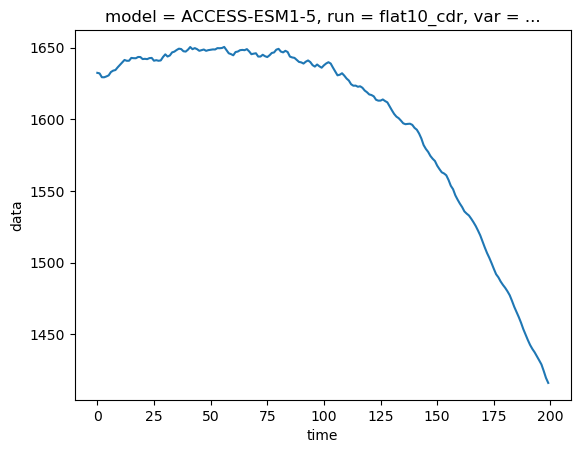

In [21]:
# to load data from this ds

# Access data for one model, run, var, latrange

subset = ds_C_global.sel(model=modellist[0], run=runlist[2], var='cTot', latrange='global')

print(subset)

subset.data[0:200].plot()

# #---------# Snippets below #-----------#